# What's that Doggy in the Window?
## Explorative Data Analysis

By: **Bryan Santos**

Have you ever wanted to know the breed of dogs you see in social media or in parks because you found they look suitable for yourself?

This project aims to build an application that lets users upload images of a dog and get its breed. The application will then assess the breed characteristics if it is suitable for the user based on lifestyle. If it is, then the system will redirect the user to a dog of that particular breed that is up for adoption.

The project will utilize multi-class image classification and recommendation systems machine learning models to achieve its goals.

The pet industry is a multi-billion dollar industry even just in the United States alone. The trend of owning pets is on a steady rise. Unfortunately, so do the number of dogs that would be without a permanent home or that would be euthanized. Many people buy dogs because of fad or appearances and abandon them, most likely because they do not realize that dogs of different breeds have unique characteristics and may not necessarily match their lifestyles.

***

This notebook contains all explorative data analysis as deep-dives conducted on the various dataset. I will look at various visualizations and write the observations that may play as key factors in the multi-class image classification and recommendation system modeling.

Note that this version of the EDA only contains analysis and observations on the images gathered from www.dog.ceo and Udacity. The succeeding version of this notebook will include EDA on dog breed characteristics, attributes and actual dogs for adoption.

## 1: Package Imports and Data Load

### Package Imports

Below are the libraries needed to visualize data to draw key insights and observations.

In [84]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
plt.style.use('fivethirtyeight')
import cv2
import tqdm
from sklearn.datasets import load_files
from glob import glob
from random import randint
import os
import PIL

In [85]:
%%capture

from tqdm import tqdm_notebook as tqdm
from tqdm import tnrange
tqdm().pandas()

### Data Load

In [9]:
### Load record of all images and aggregated count
images_df = pd.read_csv('images_df.csv')
count_df = pd.read_csv('count_df.csv')

In [10]:
### Drop unneccesary column then validate
del images_df['Unnamed: 0']
images_df.head(5)

,filename,breed
0,yr5nolw2d8qzb9i3scg4.jpg,setter-irish
1,01g4tqhjevrdzo3pl2ky.jpg,setter-irish
2,lhyq7io1ek6gbwuc2tn8.jpg,setter-irish
3,5971pwrfx0hunc3m4el2.jpg,setter-irish
4,o6vqbkigf4n32xmzrls5.jpg,setter-irish


In [11]:
### Drop unneccesary column then validate
del count_df['Unnamed: 0']
count_df.tail(5)

,breed,count
168,terrier-smooth-fox,38
169,griffon-wirehaired-pointing,37
170,terrier-manchester,36
171,plott,35
172,buhund-norwegian,33


In [12]:
### Drop unneccesary column then validate
labels_df = pd.read_csv('labels.csv')
del labels_df['Unnamed: 0']

In [34]:
### Drop unneccesary column then validate
split_df = pd.read_csv('targets_df.csv')
del split_df['Unnamed: 0']

In [36]:
split_df.head(5)

,filename,breed
0,m8045hqkl3wiado97pcb.jpg,maltese
1,51n7gcvmu9x2e8wfoql6.jpg,maltese
2,its279rcqnjuz6eao03w.jpg,maltese
3,mzhr9l61d3j4sqogbu5n.jpg,maltese
4,wurbzx6jnvgep8d4mao2.jpg,maltese


## 2: EDA - Images Dataset

This section contains all deep-dives of the images dataset gathered from the two sources.

### What is the class distribution?

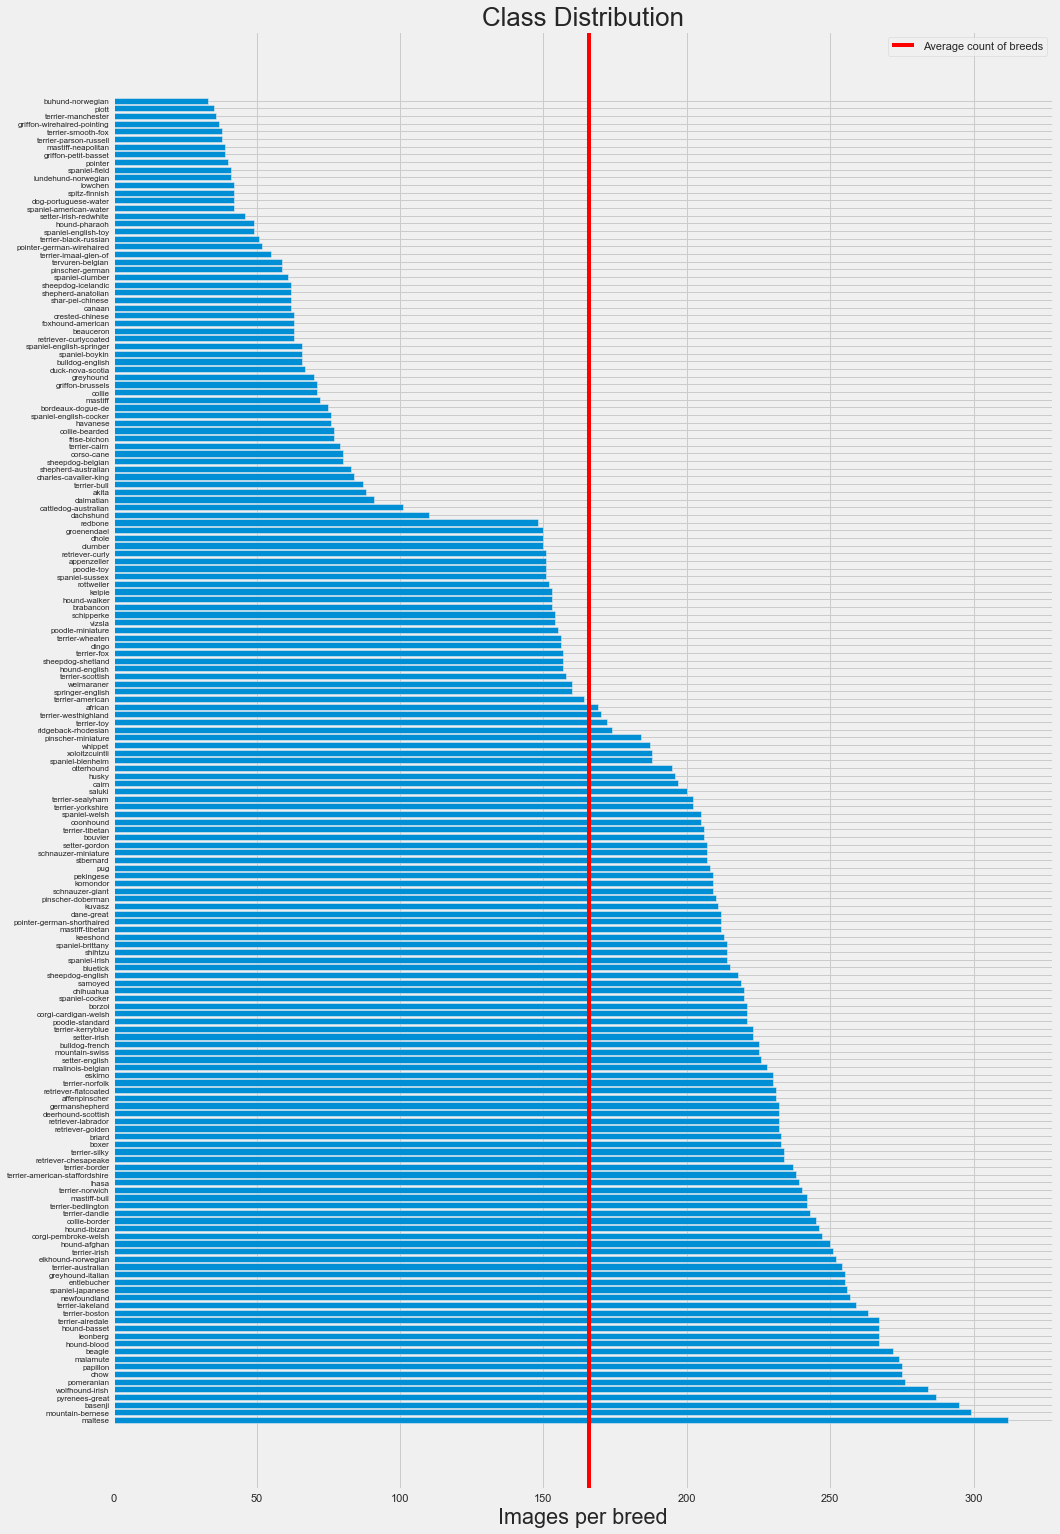

In [107]:
### Plot class distribution

plt.style.use('fivethirtyeight')
plt.rcParams.update({'font.size': 18})

fig, ax = plt.subplots(figsize=(15,25))

ax.barh(count_df["breed"],count_df["count"])
ax.axvline(count_df["count"].mean(), color="red", label="Average count of breeds")

ax.set_yticklabels(count_df["breed"], fontsize=8)

ax.set_xlabel("Images per breed")
ax.set_title('Class Distribution')
ax.legend()

plt.show()

#### Observations:

The first observation that comes to mind is the number of classes. There are a total of 173 breeds making this a complex multi-class image classification. Furthermore, there is also a wide disparity in the amount of images available for each class, resulting to an obvious class imbalance. The red line shows the mean count of all classes and approximate half are quite below the red line. 

There are various ways that I could deal with the class imbalance. I am predicting that our model to be build from scratch will perform very poorly given the lack of observations for half of the breeds. However, I am confident that using pre-trained models via Transfer Learning can help solve this problem. We will compensate the lack of images for some of the breeds by tapping into the other images that the pre-trained models have trained on.

### Random Image

This section just shows a random image so readers will get an idea on the kind of images that this project is using.

In [18]:
# define function to load train, test, and validation datasets
def load_dataset(path):
    data = load_files(path)
    dog_files = np.array(data['filenames'])
    dog_targets = np_utils.to_categorical(np.array(data['target']), 173)
    return dog_files, dog_targets

# load train, test, and validation datasets
train_files, train_targets = load_dataset('backup/2/images/train')
valid_files, valid_targets = load_dataset('backup/2/images/validation')
test_files, test_targets = load_dataset('backup/2/images/test')

# load list of dog names
dog_names = [item for item in sorted(glob("backup/2/images/train/*/"))]

# print statistics about the dataset
print('There are %d total dog categories.' % len(dog_names))
print('There are %s total dog images.\n' % len(np.hstack([train_files, valid_files, test_files])))
print('There are %d training dog images.' % len(train_files))
print('There are %d validation dog images.' % len(valid_files))
print('There are %d test dog images.'% len(test_files))

There are 173 total dog categories.
There are 28669 total dog images.

There are 18553 training dog images.
There are 4309 validation dog images.
There are 5807 test dog images.


In [19]:
def random_image(num):
    '''
    This function shows a sample image in the training set. 
    
    Parameters:
    - Number out of the total images (20,000++)
    
    Output:
    - Displays the image
    
    '''
    image = cv2.imread(train_files[num])
    cv_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(cv_rgb)
    plt.show()

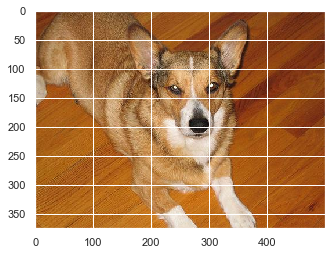

In [20]:
### Show a random image using the function
random_image(5)

### Random Image Grid

This part of the notebook displays random images on a 3x3 grid. The purpose of this is to show the breeds and how much different they look.

In [21]:
def plot_images(images, classes):
    '''
    This function displays nine random images on a 3x3 grid. 
    
    Parameters:
    - images = images to show
    - classes = breeds to show
    
    Output:
    - Displays a 3x3 image greed
    
    '''
    assert len(images) == len(classes) == 9
    
    ### Create figure with 3x3 sub-plots
    fig, axes = plt.subplots(3, 3,figsize=(60,60),sharex=True)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)
   
    for i, ax in enumerate(axes.flat):
        
        ### Plot image
        ax.imshow(cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB).reshape(img_width,img_height,3), cmap='hsv')    
        xlabel = "Breed: {0}".format(classes[i])
    
        ### Show the classes as the label on the x-axis
        ax.set_xlabel(xlabel)
        ax.xaxis.label.set_size(60)
        
        ### Remove ticks from the plot
        ax.set_xticks([])
        ax.set_yticks([])
    
    plt.show()

But before I can display the different dogs, I wanted to first ensure that they are of the same image size so our plot looks standard and consistent.

In [38]:
img_width = 250
img_height = 250
images = []
classes = []

### Load training images
for f, breed in tqdm(split_df.values):
    img = cv2.imread('images/train/' + f)
    classes.append(breed)
    try:
        images.append(cv2.resize(img, (img_width, img_height)))
    except: 
        continue

Images to show: 9
Classes to show: 9


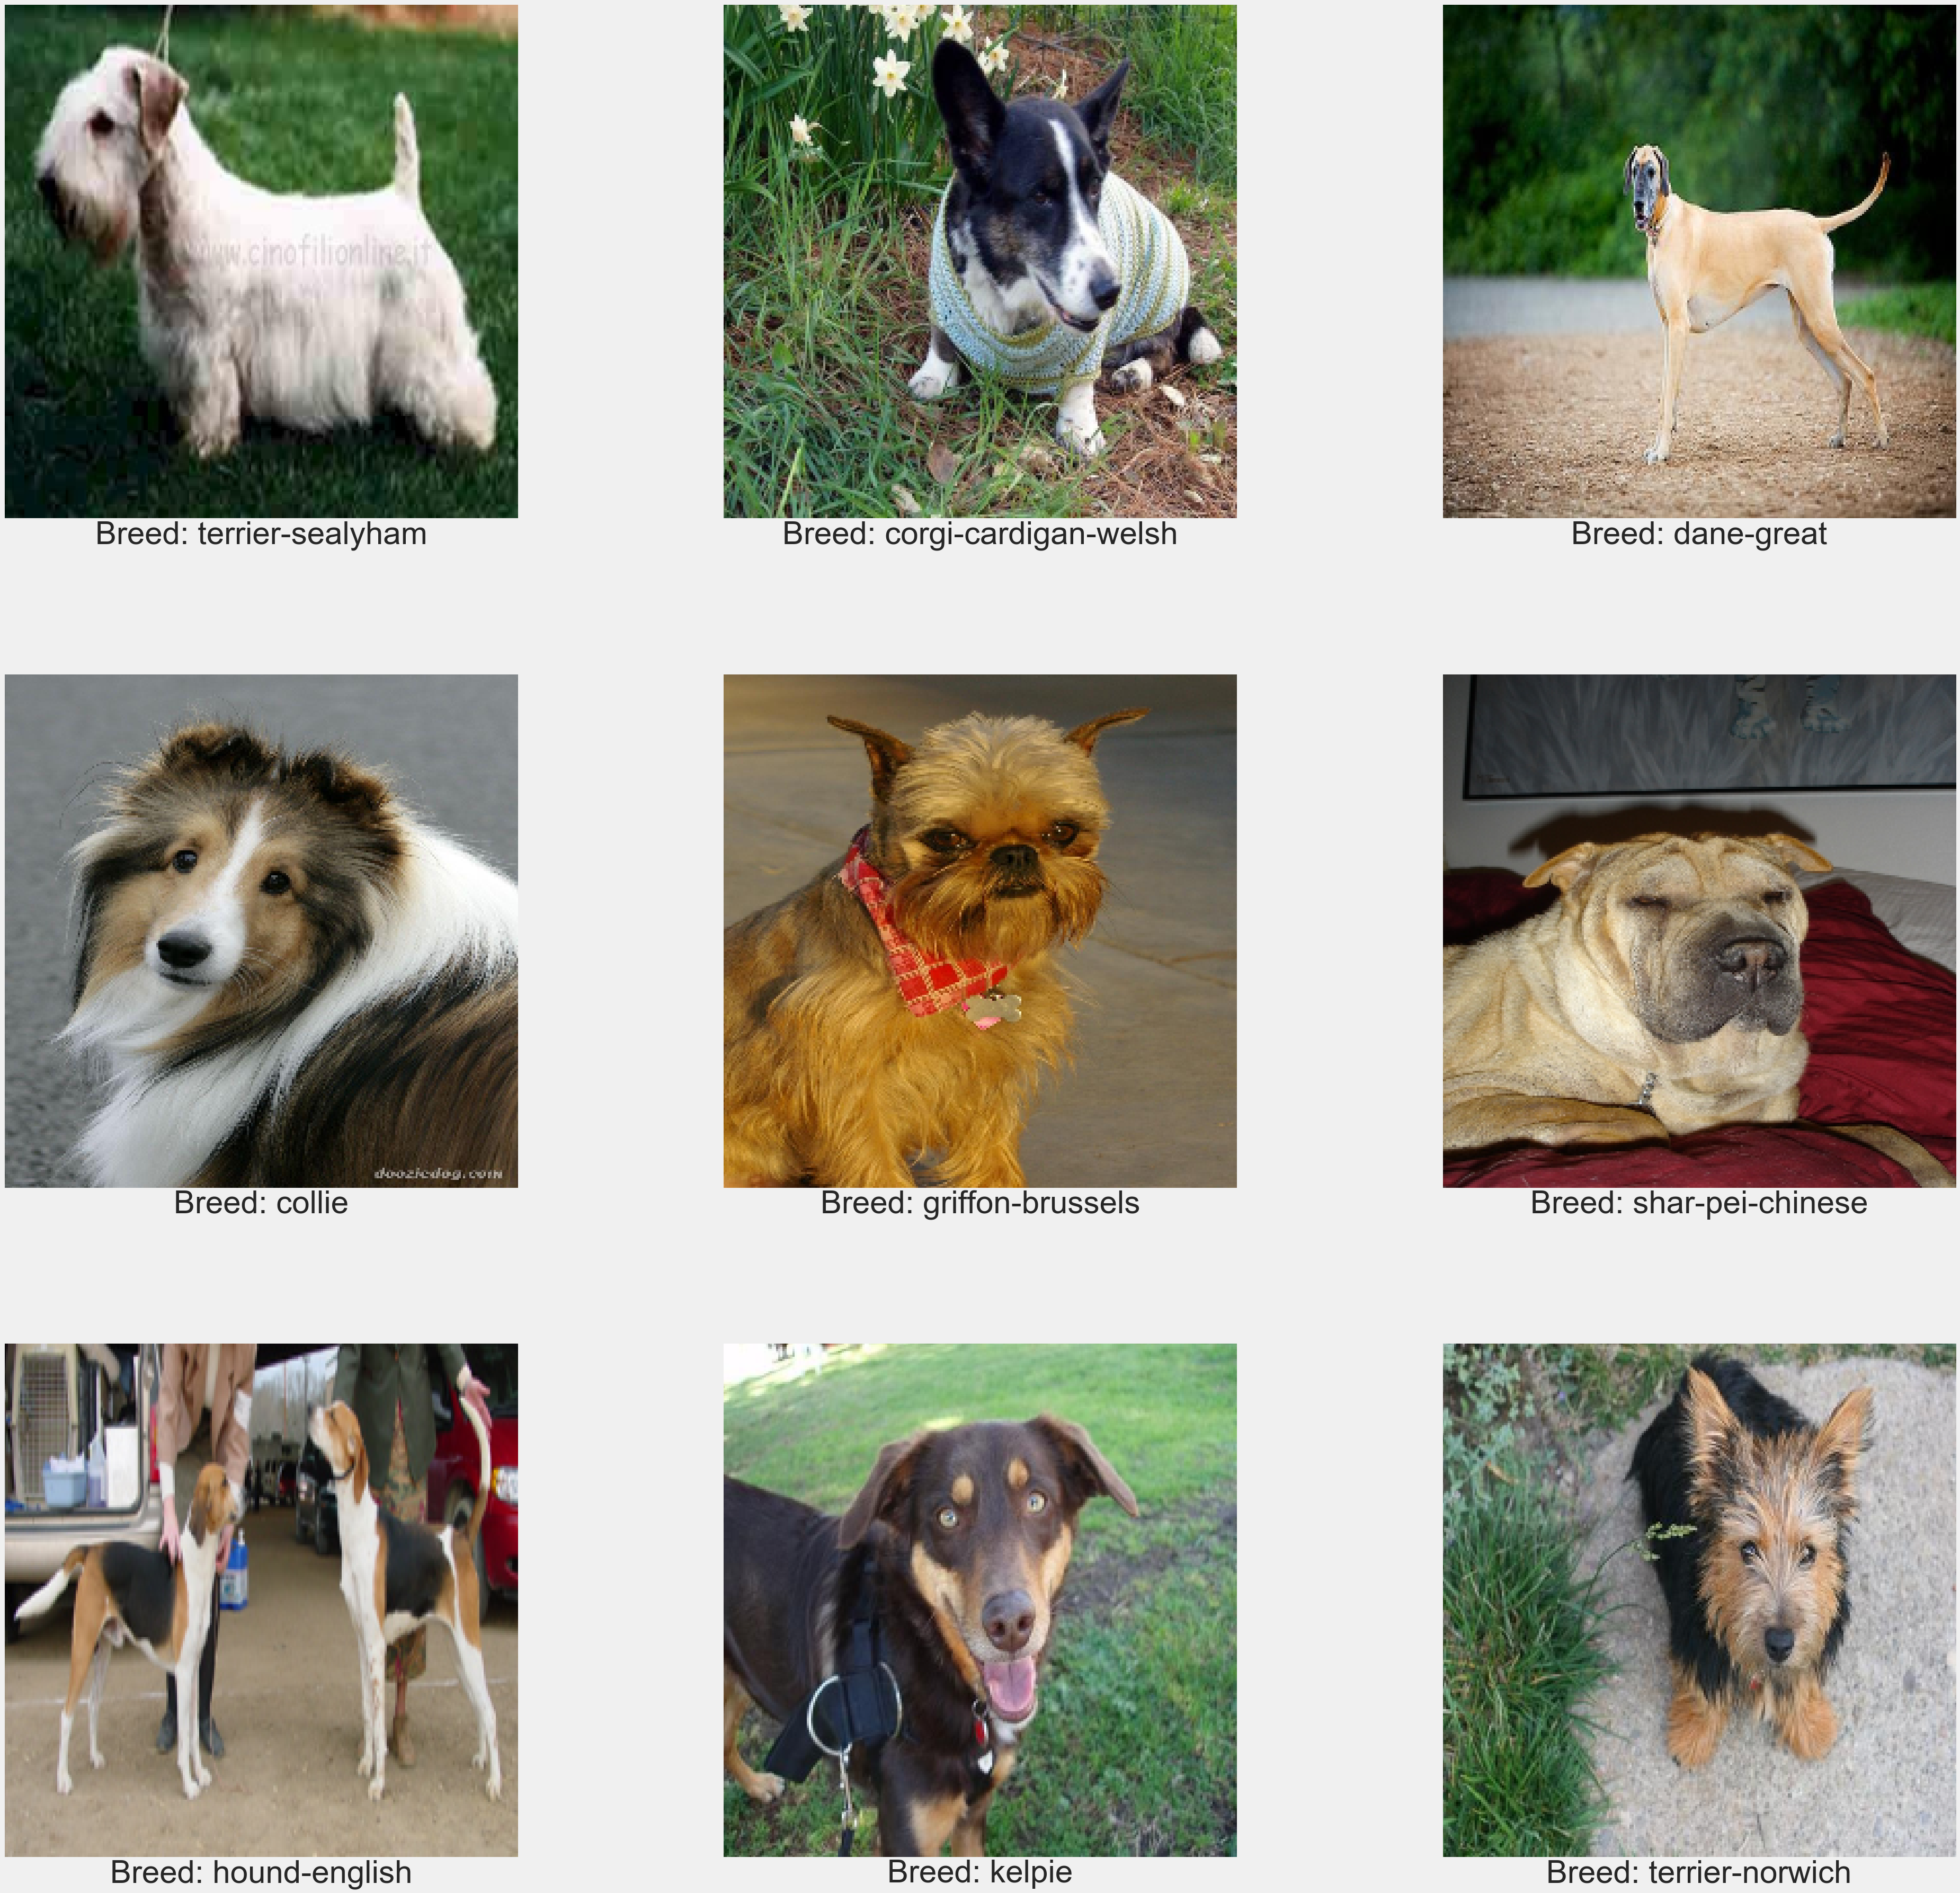

In [40]:
### Select random images
random_numbers = [randint(0, len(images)) for p in range(0,9)]
images_to_show = [images[i] for i in random_numbers]
classes_to_show = [classes[i] for i in random_numbers]
print("Images to show: {0}".format(len(images_to_show)))
print("Classes to show: {0}".format(len(classes_to_show)))

### Plot the images
plot_images(images_to_show, classes_to_show)

#### Observations:

Given the wide variety of dogs as seen in the random images, this proves that there is indeed a need for a dog breed classifier. Normal folks would find it hard to identify a dog's breed because of the significant physical differences and the actual number of breeds there are. 

### Image Sizes

This looks into the file sizes of images. It may be noteworthy to check if file sizes do matter in making predictions.

In [41]:
### Get image paths
path_df = split_df.copy()
path_df.columns

Index(['filename', 'breed'], dtype='object')

In [45]:
path_df['path'] = 'images/train/' + path_df.filename

In [46]:
path_list = path_df.path 

In [51]:
### Prepare a dataframe to store file sizes
sizes_df = pd.DataFrame(columns=['path', 
                                'size']) 

### Get file sizes
for path in tqdm(path_list):
    size = os.path.getsize(path)
    sizes_df = sizes_df.append({'path': path, 'size': size}, ignore_index = True)


### Store file sizes
sizes_df.to_csv('sizes.csv')

In [63]:
sizes_df.head(5)

,path,size
0,images/train/m8045hqkl3wiado97pcb.jpg,18908
1,images/train/51n7gcvmu9x2e8wfoql6.jpg,25131
2,images/train/its279rcqnjuz6eao03w.jpg,642264
3,images/train/mzhr9l61d3j4sqogbu5n.jpg,18966
4,images/train/wurbzx6jnvgep8d4mao2.jpg,24394


In [64]:
filesizes = pd.Series(sizes_df['size'])

In [65]:
filesizes

0         18908
1         25131
2        642264
3         18966
4         24394
          ...  
28661     26704
28662    211184
28663     70848
28664     37235
28665    324217
Name: size, Length: 28666, dtype: object

For more straightforward analysis, it is best to scale all file sizes in kilobytes.

In [66]:
### Make the sizes in kilobytes
filesizes = filesizes / 1000

In [67]:
filesizes

0         18.908
1         25.131
2        642.264
3         18.966
4         24.394
          ...   
28661     26.704
28662    211.184
28663     70.848
28664     37.235
28665    324.217
Name: size, Length: 28666, dtype: object

Let's plot the file sizes.

Text(0.5, 1.0, 'Size Distribution')

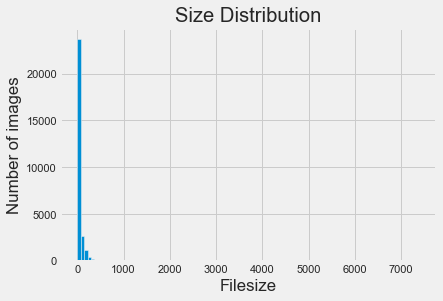

In [72]:
plt.hist(filesizes, bins=100) # `density=False` would make counts
plt.ylabel('Number of images')
plt.xlabel('Filesize');
plt.title('Size Distribution')

#### Observations:

There are apparent massive outliers which have larges file sizes when compared to the majority. Some are even 7MB in size which makes these images bigger and probably clearer. 

It may be useful to zoom in on the graph above even further to assess the distribution of the majority of the file sizes, outside of the outliers. The function below removes the outliers from the graph.

In [74]:
def is_outlier(points, thresh=3.5):
    """
    Returns a boolean array with True if points are outliers and False 
    otherwise.

    Parameters:
    - points : Number of observations by numdimensions array of observations
    - threshold : The modified z-score to use as a threshold

    Returns:
    - mask : Boolean array excluding outliers

    """
    if len(points.shape) == 1:
        points = points[:,None]
    median = np.median(points, axis=0)
    diff = np.sum((points - median)**2, axis=-1)
    diff = np.sqrt(diff)
    med_abs_deviation = np.median(diff)

    modified_z_score = 0.6745 * diff / med_abs_deviation

    return modified_z_score > thresh

In [78]:
filesizes = np.array(filesizes, dtype = np.float64)

Text(0.5, 1.0, 'Size Distribution (w/o Outliers)')

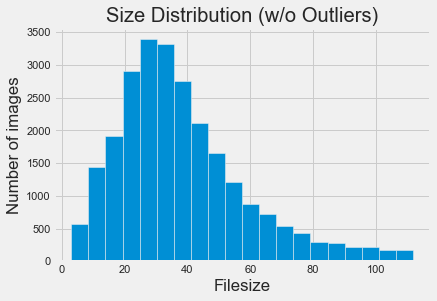

In [79]:
### Only keep non-outliers
filtered = filesizes[~is_outlier(filesizes)]

plt.hist(filtered, bins=20) # `density=False` would make counts
plt.ylabel('Number of images')
plt.xlabel('Filesize')
plt.title('Size Distribution (w/o Outliers)')

#### Observations:

Majority of the images haev around 30kb of filesizes only. It is interesting whether this may play a significant factor in predicting the breeds when most of the images sizes, effectively the quality, are smaller. Then again, I still need to maintain the file sizes small to be manageable enough when running complex algorithms because of time and performance concerns.

Based on the analysis, I believe I will need to resize all images prior to modeling.

### Image Dimensions

This looks into the photo dimensions of images. It may be noteworthy to check if image width and height do matter in making predictions.

In [86]:
### Prepare a dataframe to store file dimensions
dimension_df = pd.DataFrame(columns=['path', 
                                'width', 'height']) 

### Get file width and height
for path in tqdm(path_list):
    image = PIL.Image.open(path)
    width, height = image.size
    dimension_df = dimension_df.append({'path': path, 'width': width, 'height': height}, ignore_index = True)


### Store file sizes
dimension_df.to_csv('dimension_df.csv')

In [87]:
dimension_df.head(5)

,path,width,height
0,images/train/m8045hqkl3wiado97pcb.jpg,500,333
1,images/train/51n7gcvmu9x2e8wfoql6.jpg,422,317
2,images/train/its279rcqnjuz6eao03w.jpg,1026,1317
3,images/train/mzhr9l61d3j4sqogbu5n.jpg,500,373
4,images/train/wurbzx6jnvgep8d4mao2.jpg,374,500


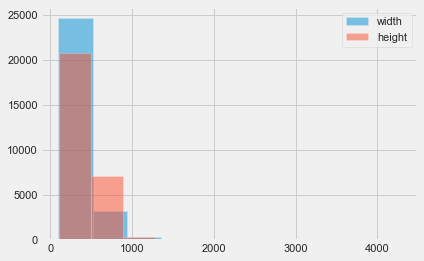

In [94]:
x = dimension_df['width']
y = dimension_df['height']

plt.hist(x, alpha=0.5, label='width')
plt.hist(y, alpha=0.5, label='height')
plt.legend(loc='upper right')
plt.tit
plt.show()

#### Observations:

There are apparent massive outliers which have larges file dimensions when compared to the majority.

It may be useful to zoom in on the graph above even further to assess the distribution of the majority of the file dimensions, outside of the outliers. I will reuse the function above that removes outliers.

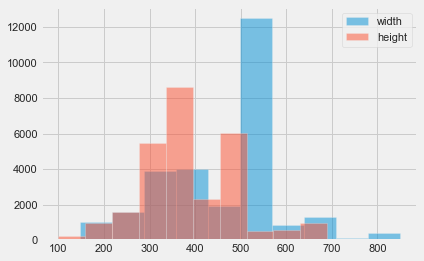

In [97]:
### Only keep non-outliers
width = dimension_df['width']
height = dimension_df['height']
width = np.array(width, dtype = np.float64)
height = np.array(height, dtype = np.float64)
width = width[~is_outlier(width)]
height = height[~is_outlier(height)]

x = width
y = height

plt.hist(x, alpha=0.5, label='width')
plt.hist(y, alpha=0.5, label='height')
plt.legend(loc='upper right')
plt.show()

#### Observations:

The height of the images looks more normally distributed versus its height. This suggests many of the photos may be taken in landscape mode. Again, it will be interesting to see if this plays a factor in predictive accuracy of our models later. But then I also believe that it might be best to resize all images prior to modeling to ensure equal weight distribution.